# Term Deposit Marketing Project

## Background:

We are a small startup focusing mainly on providing machine learning solutions in the European banking market. We work on a variety of problems including fraud detection, sentiment classification and customer intention prediction and classification.

We are interested in developing a robust machine learning system that leverages information coming from call center data.

Ultimately, we are looking for ways to improve the success rate for calls made to customers for any product that our clients offer. Towards this goal we are working on designing an ever evolving machine learning product that offers high success outcomes while offering interpretability for our clients to make informed decisions.

## Data Description:

The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.

### Attributes:

- age : age of customer (numeric)

- job : type of job (categorical)

- marital : marital status (categorical)

- education (categorical)

- default: has credit in default? (binary)

- balance: average yearly balance, in euros (numeric)

- housing: has a housing loan? (binary)

- loan: has personal loan? (binary)

- contact: contact communication type (categorical)

- day: last contact day of the month (numeric)

- month: last contact month of year (categorical)

- duration: last contact duration, in seconds (numeric)

- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

### Output (desired target):

- y - has the client subscribed to a term deposit? (binary)

## Summary of the Project:

Our Analysis was conducted following these steps:

1. Import Libraries and Load Data
2. Data preprocessing
3. Exploratory Data Analysis (EDA) - get insights for the company, handle imbalanced dataset and categorical features
4. Create a base model using Lazypredict library for testing multiple model
5. Feature Importance
6. Train Final Model

### Insights:

* The dataset was clean with no missing, null or duplicated values.
* There were some clients, who subscripted with negative balance. This does not make sense and maybe is a mistake on these observations of the dataset.
* The majority of those who have defaulted before or have a personal loan or have a housing loan have not subscribed to a term deposit.

We also saw that clients are more likely to subscribe if: 

1) have tetriary education
2) are student
3) are having a cellular contact with the company
4) their last contact month: october
5) they are single (marital)

### Conclusion:

* As we saw the duration was the most important feature in predicting if the client will subsribe or not. The client who would want to buy is likely to stay longer on the call in order to know more about the program.
And the company should persuade the client with last call duration of 11 - 35 minutes. 
* Also, our model with 90% accuracy on predicting the client's subscription or not will save them time and money.

### Import Libraries

In [30]:
# random
import random

# cell output clear tool
from IPython.display import clear_output

# data
import pandas as pd
import numpy as np

# visualisations
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# basic models
import lazypredict
from lazypredict.Supervised import LazyClassifier

# shap
import shap

#chisquare
from scipy.stats import chi2_contingency

# sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.inspection import permutation_importance

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

### Load Data and Data Preprocessing

In [3]:
# load dataset
data = pd.read_csv("Data/term-deposit-marketing-2020.csv")
original_data = data.copy()
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [4]:
# get info about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


* There are no missing or null data to replace in the dataset
* We have 5 numerical features and 9 categorical features

In [5]:
# see if there are duplicates rows in the data
sum(data.duplicated())

0

* There are no duplicated rows to drop

### Exploratory Data Analysis (EDA)

In [6]:
# Check for unique labels in each CATEOGRICAL column
for col in data.columns:
    if(data[col].dtype.name != 'object'): continue
    print(f'{col}: {len(data[col].unique())} unique values\n')
    print(f'{data[col].unique()}\n')

job: 12 unique values

['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']

marital: 3 unique values

['married' 'single' 'divorced']

education: 4 unique values

['tertiary' 'secondary' 'unknown' 'primary']

default: 2 unique values

['no' 'yes']

housing: 2 unique values

['yes' 'no']

loan: 2 unique values

['no' 'yes']

contact: 3 unique values

['unknown' 'cellular' 'telephone']

month: 11 unique values

['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr']

y: 2 unique values

['no' 'yes']



In [7]:
# Get statistics about the numeric features
data.describe()

,age,balance,day,duration,campaign
count,40000.00,40000.00,40000.00,40000.00,40000.00
mean,40.54,1274.28,16.02,254.82,2.88
std,9.64,2903.77,8.28,259.37,3.24
min,19.00,-8019.00,1.00,0.00,1.00
25%,33.00,54.00,8.00,100.00,1.00
50%,39.00,407.00,17.00,175.00,2.00
75%,48.00,1319.00,21.00,313.00,3.00
max,95.00,102127.00,31.00,4918.00,63.00


* Age and Day are looking good with their values
* Balance has some negative values which will be investigated
* Balance, duration and campaign maybe have some outliers

In [8]:
print('balance:')
print(data[data['balance']<=0]['y'].value_counts())

balance:
no     6564
yes     376
Name: y, dtype: int64


* We see that 376 clients subscribed with negative balanced. This does not make sense subscribing with negative balance to a term deposit.

In [9]:
print('duration:')
print(data[data['duration']==0]['y'].value_counts())

duration:
no    3
Name: y, dtype: int64


* The clients with 0 duration calls have not subscribed, which makes sense.

In [10]:
# categorical and numerical features
categorical_features = []
numerical_features = []
for col in data.columns:
  if data[col].dtype == 'object':
    categorical_features.append(col)
  elif data[col].dtype == 'int64':
    numerical_features.append(col)
print(f'Categorical features: {categorical_features}')
print(f'Numerical features: {numerical_features}')

Categorical features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'y']
Numerical features: ['age', 'balance', 'day', 'duration', 'campaign']


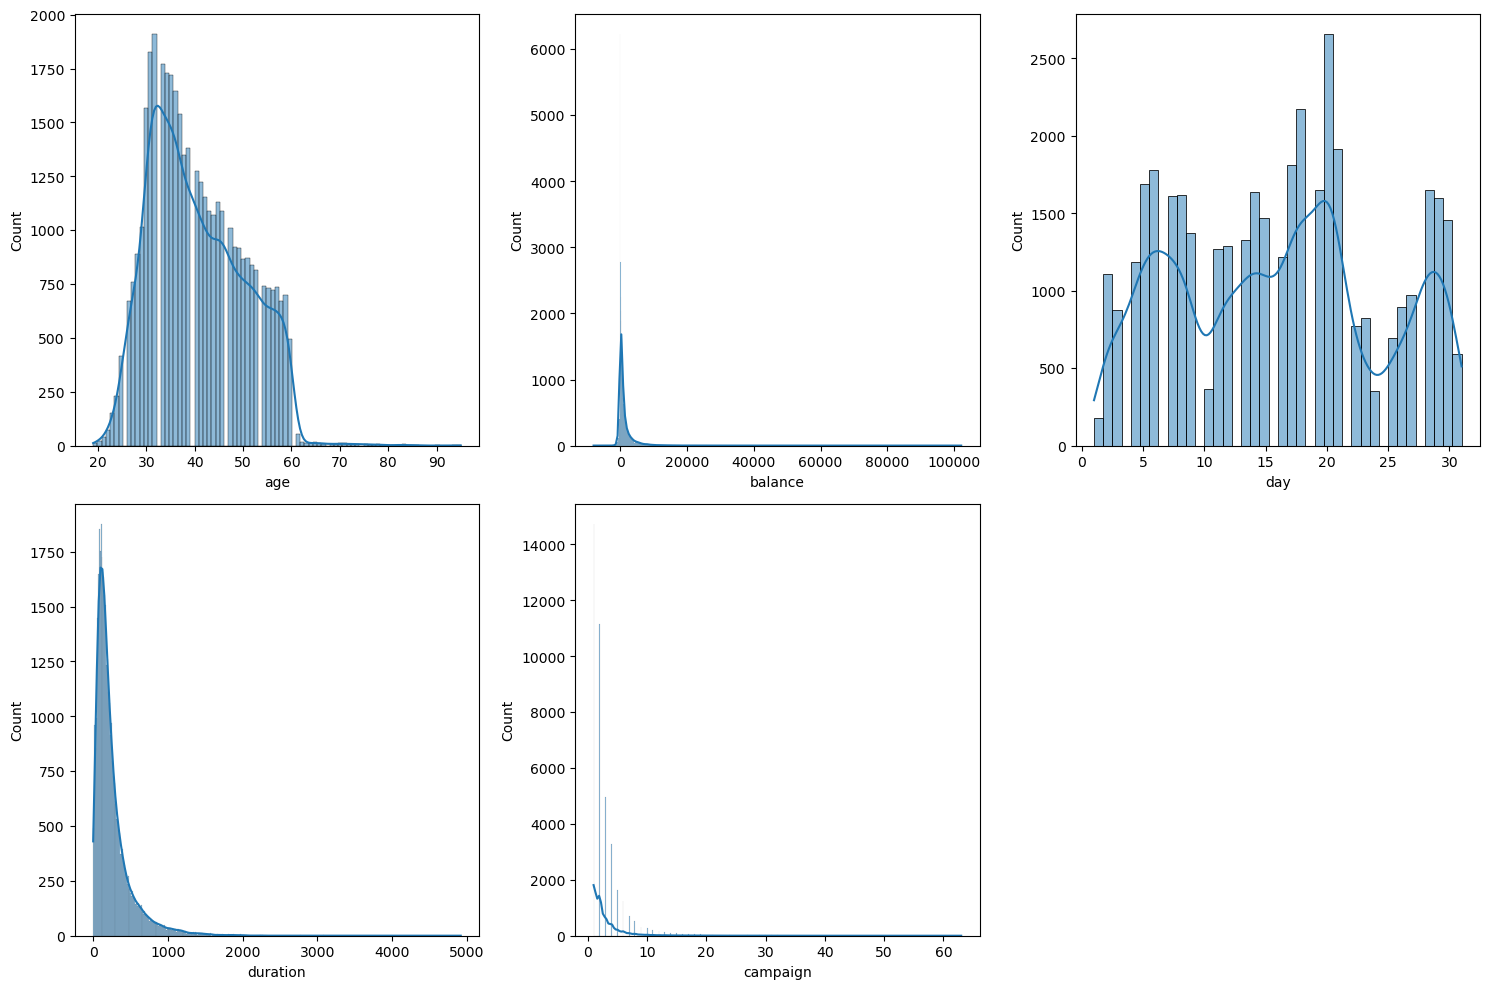

In [11]:
# distributions of numerical data
plt.figure(figsize=(15,10))
i = 1 
for col in numerical_features:
  ax = plt.subplot(2,3,i)
  sns.histplot(data=data, x=col, kde=True)
  i+=1
plt.tight_layout()
plt.show()

* Most of our numerical features have a right skewed distribution

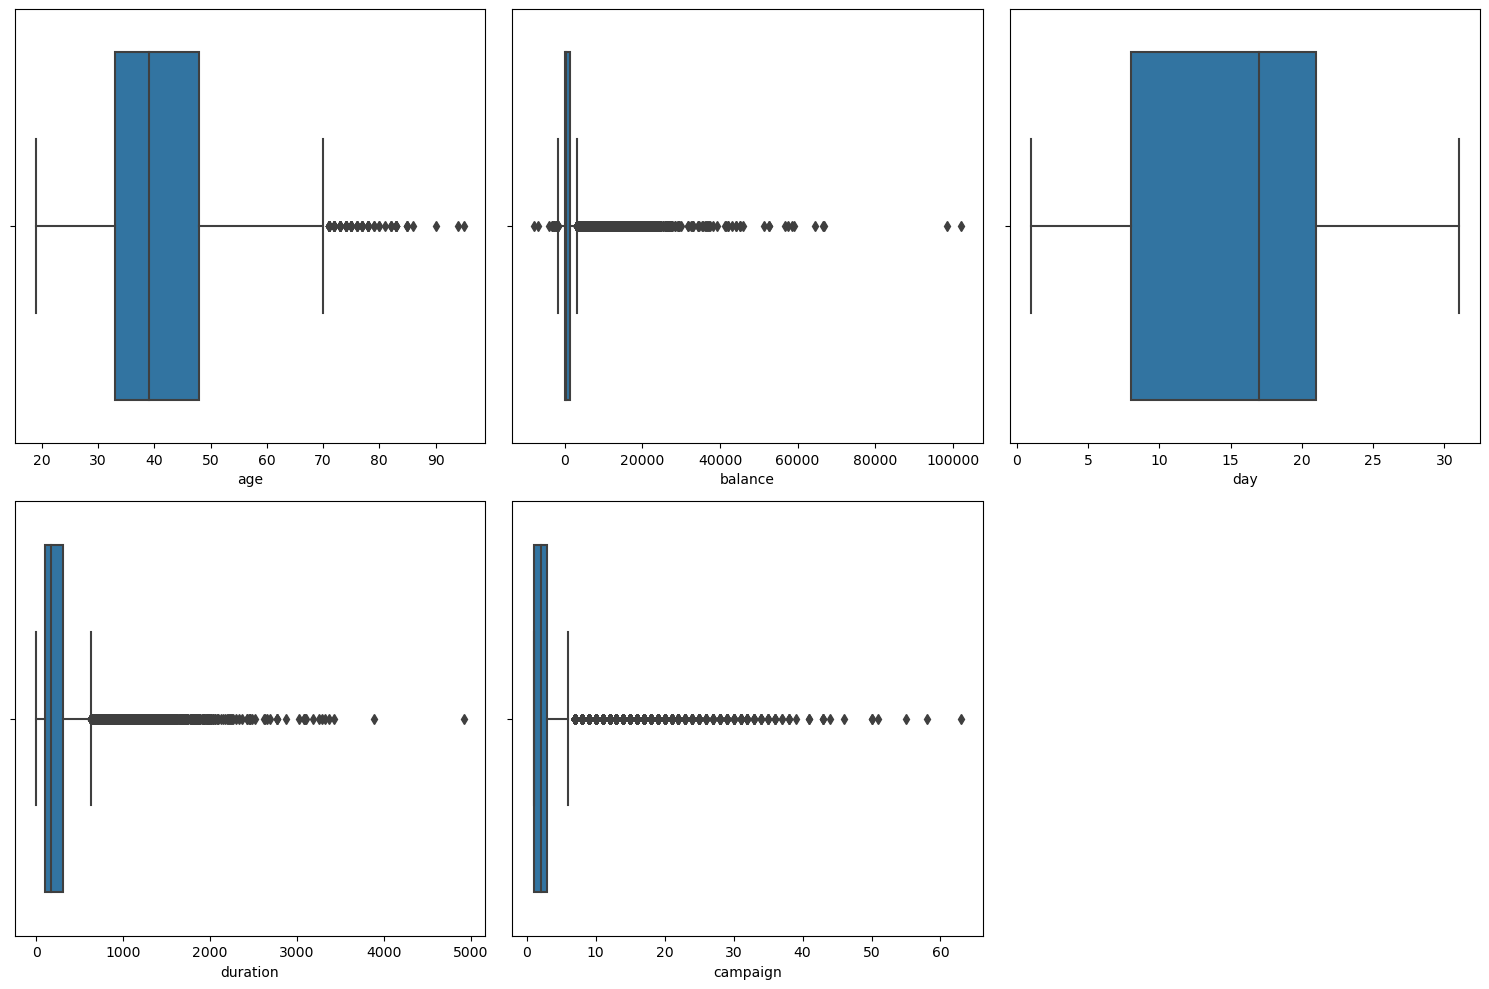

In [12]:
# boxplot to see for outliers
plt.figure(figsize=(15,10))
i = 1 
for col in numerical_features:
  ax = plt.subplot(2,3,i)
  sns.boxplot(data=data, x=col)
  i+=1
plt.tight_layout()
plt.show()

* Duration, campaign, balance and age we see having some outliers

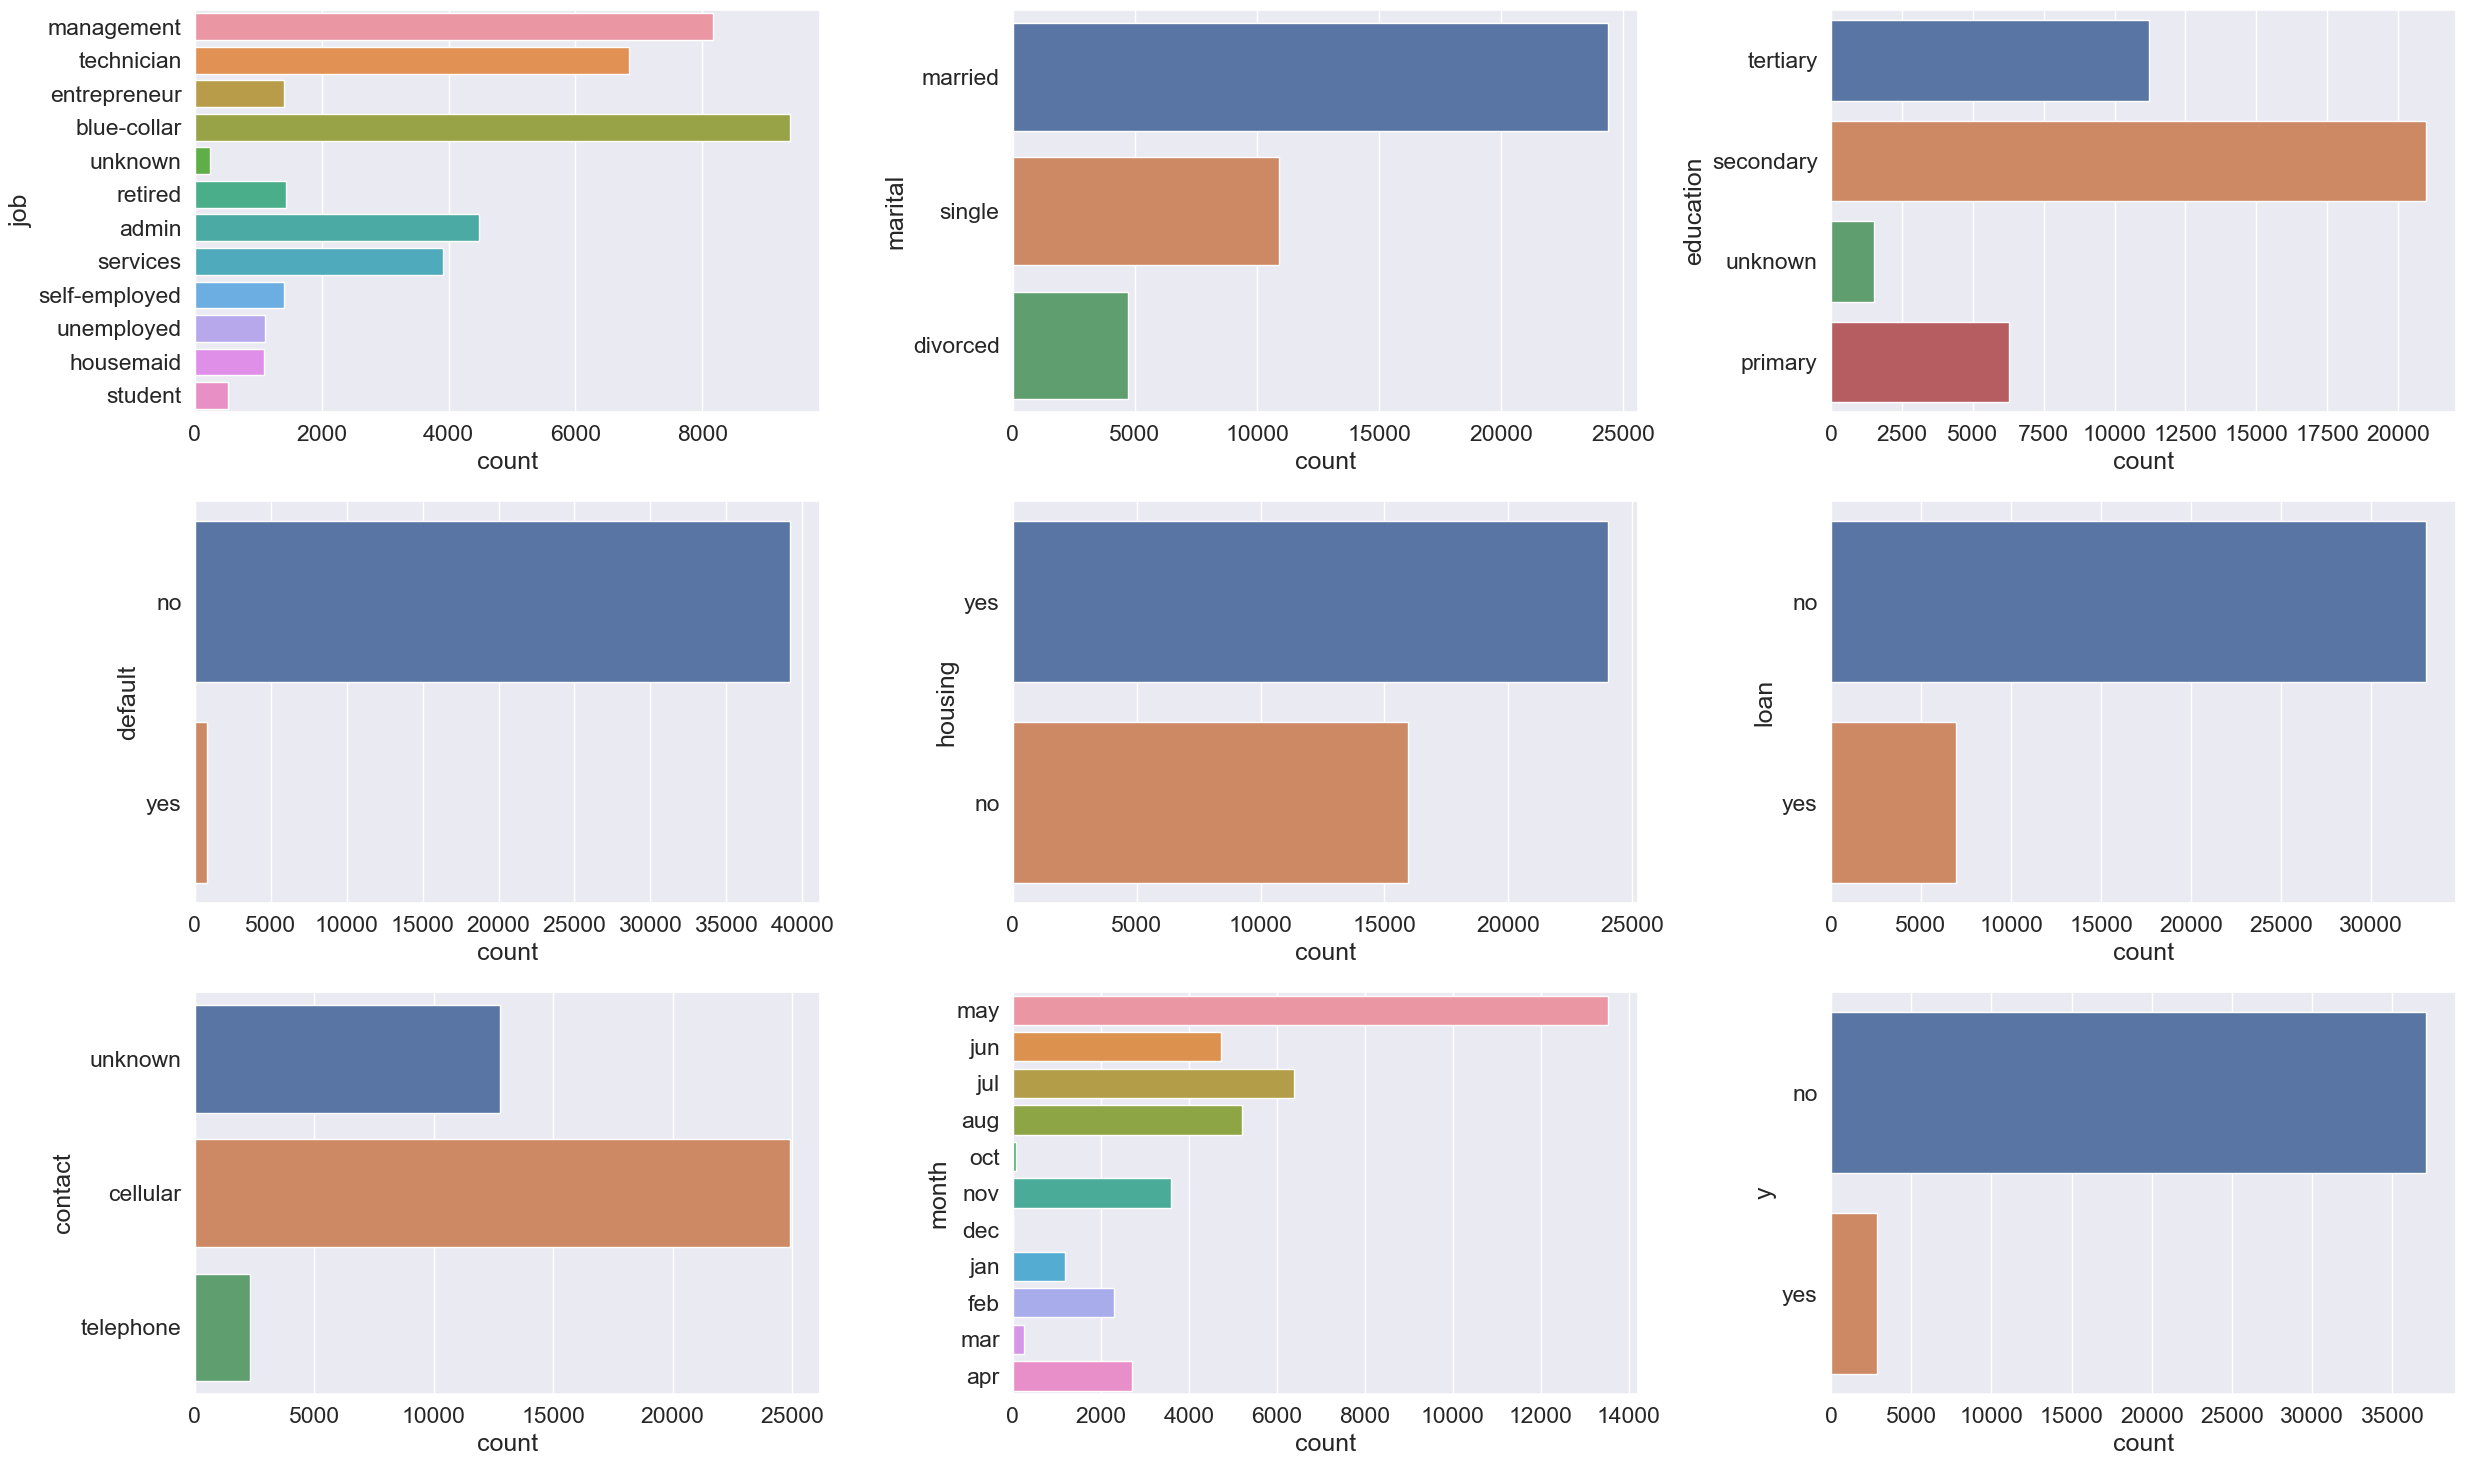

In [13]:
# countplots of categorical features
sns.set(font_scale = 1.5)
plt.figure(figsize=(25,15))
i=1
for col in categorical_features:
	ax = plt.subplot(3,3,i)
	sns.countplot(y=col,data=data)
	i += 1
plt.tight_layout()
plt.show()

In [14]:
colsldh = ['loan','default','housing']
nrows = 40000
for i,col in enumerate(colsldh):
  v1 = data[data[col]=='yes'].shape[0]
  v2 = data[data[col]=='yes']['y'].value_counts()[0]
  if i==0:
    print(f'{v1}/{nrows} have a personal loan.')
    print(f'{v2}/{v1} have not subscribed to a term deposit.')
    print('---------------------------------------------------')
  elif i==1:
    print(f'{v1}/{nrows} have defaulted before.')
    print(f'{v2}/{v1} have not subscribed to a term deposit.')
    print('---------------------------------------------------')
  else:
    print(f'{v1}/{nrows} have a housing loan.')
    print(f'{v2}/{v1} have not subscribed to a term deposit.')
    print('---------------------------------------------------')

6930/40000 have a personal loan.
6550/6930 have not subscribed to a term deposit.
---------------------------------------------------
809/40000 have defaulted before.
760/809 have not subscribed to a term deposit.
---------------------------------------------------
24031/40000 have a housing loan.
22567/24031 have not subscribed to a term deposit.
---------------------------------------------------


* The majority of those who have defaulted before or have a personal loan or have a housing loan have not subscribed to a term deposit

In [15]:
# we will replace the categories with 2 unique values with 1 or 0 using OneHotEncoding
y_converted_variable = pd.get_dummies(data['y'], drop_first=True, dtype='int64') # yes = 1, no = 0
loan_converted_variable = pd.get_dummies(data['loan'], drop_first=True, dtype='int64') # yes = 1, no = 0
housing_converted_variable = pd.get_dummies(data['housing'], drop_first=True, dtype='int64') # yes = 1, no = 0
default_converted_variable = pd.get_dummies(data['default'], drop_first=True, dtype='int64') # yes = 1, no = 0

# function to help us with replacing the new onehotencoding columns
def replace_coverted_variable(data, df, variable):
    data = pd.concat([data, df], axis=1)
    data.drop(variable, axis=1, inplace=True)
    data.rename(columns={'yes': variable}, inplace=True)
    return(data)

data = replace_coverted_variable(data, y_converted_variable, 'y')
data = replace_coverted_variable(data, loan_converted_variable, 'loan')
data = replace_coverted_variable(data, housing_converted_variable, 'housing')
data = replace_coverted_variable(data, default_converted_variable, 'default')

# move y column in the start of the data table
col = data.pop("y")
data.insert(0, col.name, col)


data.head()

,y,age,job,marital,education,balance,contact,day,month,duration,campaign,loan,housing,default
0,0,58,management,married,tertiary,2143,unknown,5,may,261,1,0,1,0
1,0,44,technician,single,secondary,29,unknown,5,may,151,1,0,1,0
2,0,33,entrepreneur,married,secondary,2,unknown,5,may,76,1,1,1,0
3,0,47,blue-collar,married,unknown,1506,unknown,5,may,92,1,0,1,0
4,0,33,unknown,single,unknown,1,unknown,5,may,198,1,0,0,0


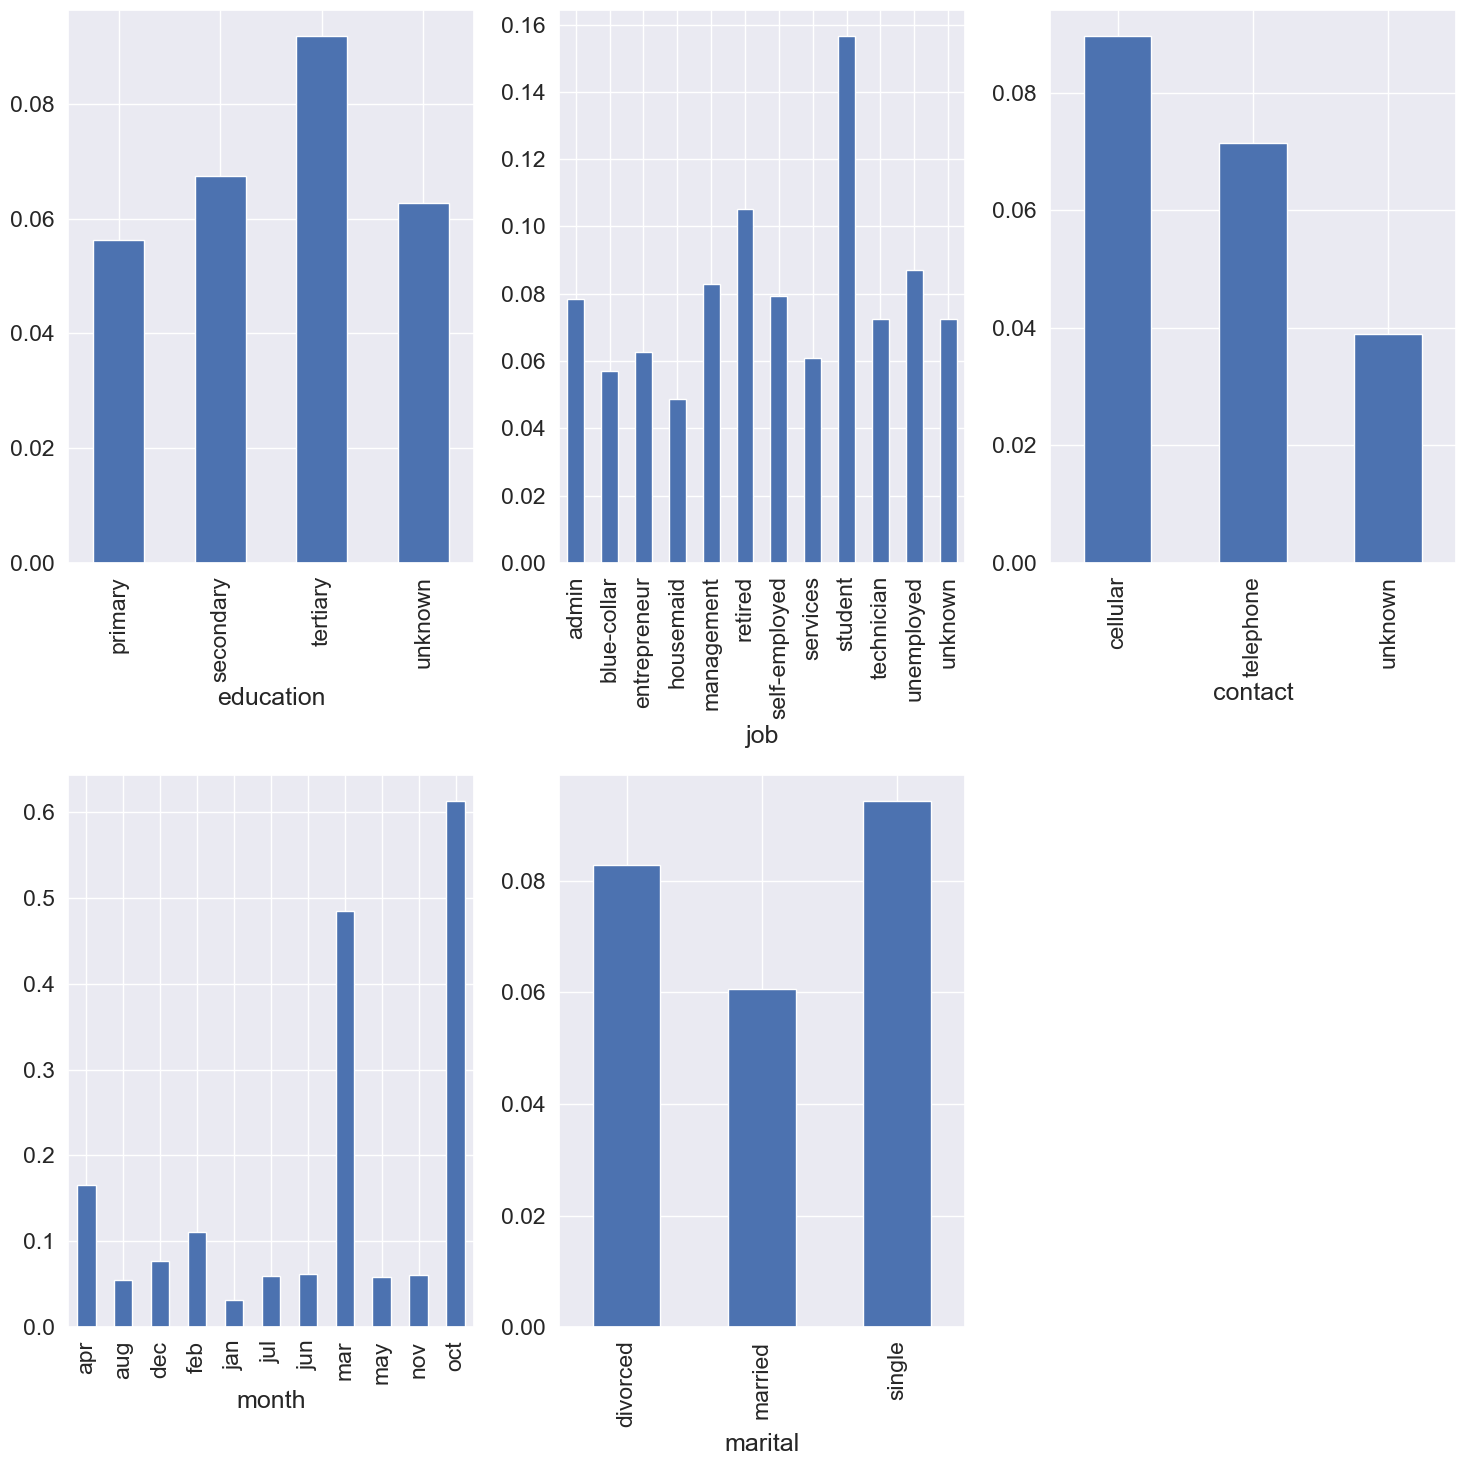

In [16]:
# Barplots of categorical features based on the corresponding mean value of the target variable
colsejcmm = ['education','job','contact','month','marital']
plt.figure(figsize=(15,15))
i = 1 
for col in colsejcmm:
  ax = plt.subplot(2,3,i)
  data.groupby([col])['y'].mean().plot.bar()
  i+=1
plt.tight_layout()
plt.show()

High probability of a client to subscribe if:

* tetriary education
* student
* cellular contact
* last contact month: october
* single (marital)

### Hypothesis Testing - Chi square test for categorical features

* H0 (null hypothesis): two features don't have any correlation between them, they are independent of each other.

* HA (alternative hypothesis): two features have a correlation between them, they are dependent of each other
---

* p-value: probability that when H0 is true, the statistical summary is equal to or greater than the actual observed results

* p < 0.05 — means that the two categorical variables are correlated.

* p > 0.05 — means that the two categorical variables are not correlated.

In [17]:
colsejcmm = ['education','job','contact','month','marital', 'y']

for i in colsejcmm:
    for j in colsejcmm:
        if i != j:
            chisqt = pd.crosstab(data[i], data[j], margins=True)
            value = np.array([chisqt.iloc[0][0:5].values,
                              chisqt.iloc[1][0:5].values])
            pval = chi2_contingency(value)[1]
            if pval <= 0.05:
                print(f'{i} and {j} are correlated!')

education and job are correlated!
education and contact are correlated!
education and marital are correlated!
education and y are correlated!
job and education are correlated!
job and contact are correlated!
job and month are correlated!
job and marital are correlated!
job and y are correlated!
contact and education are correlated!
contact and job are correlated!
contact and month are correlated!
contact and marital are correlated!
contact and y are correlated!
month and education are correlated!
month and job are correlated!
month and contact are correlated!
month and marital are correlated!
month and y are correlated!
marital and education are correlated!
marital and job are correlated!
marital and contact are correlated!
marital and month are correlated!
marital and y are correlated!
y and education are correlated!
y and job are correlated!
y and contact are correlated!
y and month are correlated!
y and marital are correlated!


### Pearson's correlation for numerical features

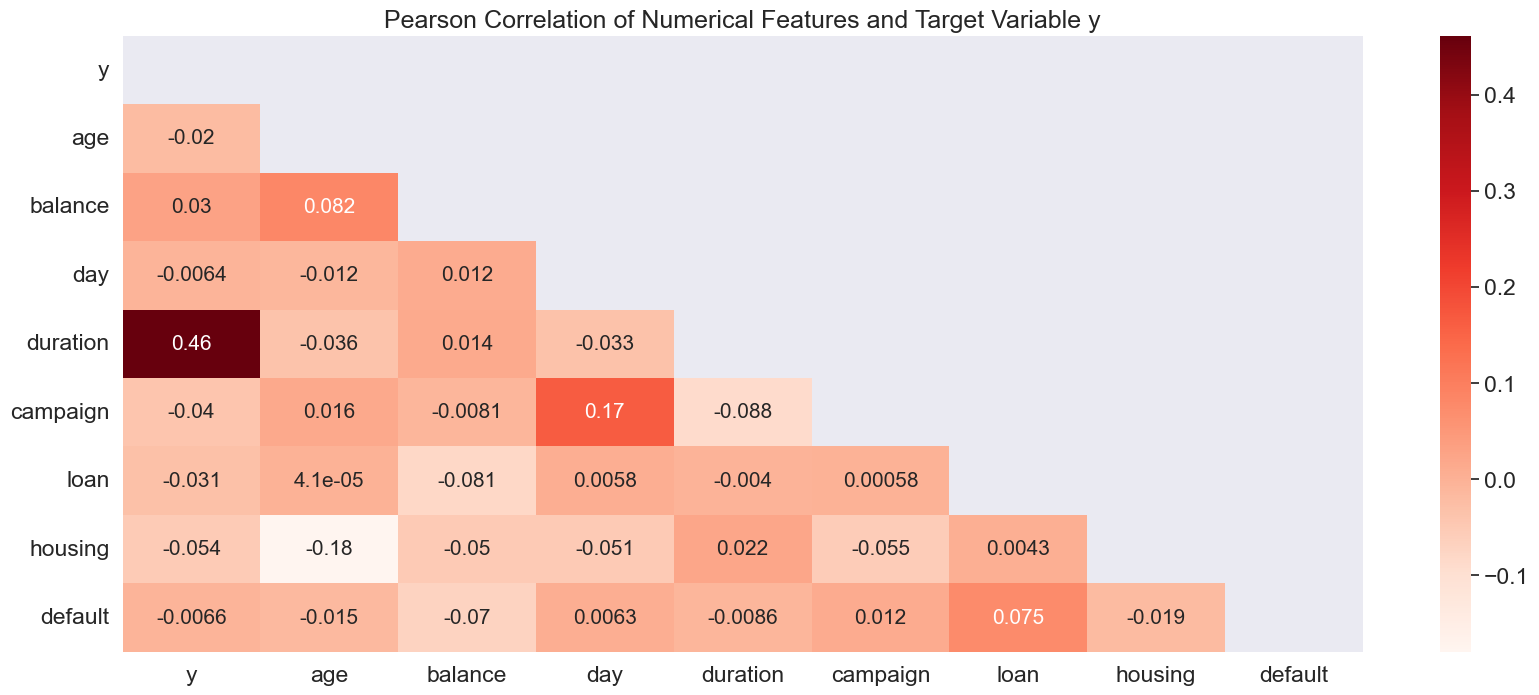

In [18]:
# Correlation Heatmap

sns.set(font_scale=1.5)

# correlation 
cor = data.corr('pearson')
matrix = np.triu(cor)

# heatmap to visualise the correlation
plt.figure(figsize=(20,8))
plt.title('Pearson Correlation of Numerical Features and Target Variable y')
sns.heatmap(cor,annot=True, cmap=plt.cm.Reds, mask=matrix,annot_kws={'size': 15})
plt.show()

### Checking for imbalanced dataset

In [19]:
df_percentage = pd.DataFrame(data['y'].value_counts())
df_percentage['Percentage (%)'] = (df_percentage['y']/df_percentage['y'].sum())*100
df_percentage

,y,Percentage (%)
0,37104,92.76
1,2896,7.24


* We see that the dataset is not balanced. 
* We will use a SMOTE (Synthetic Minority Oversampling TEchnique) to oversample the minority class.

In [20]:
# REPLACE THE CATEGORICAL DATA WITH NUMERICAL FOR BETTER PERFORMANCE IN THE MODEL
# we will replace the categories with more than 2 unique values with OrdinalNumberEncoding
# we create dictionaries for each variable and keep it for future reference
mapping_dictionary_value_job = {'management': 0, 'technician': 1, 'entrepreneur': 2, 'blue-collar': 3, 'unknown': 4,
'retired': 5, 'admin': 6, 'services': 7, 'self-employed': 8, 'unemployed': 9, 'housemaid': 10,'student': 11}

mapping_dictionary_value_month = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'oct': 10, 'nov': 11, 'dec': 12}

mapping_dictionary_value_marital = {'married': 2, 'single': 1, 'divorced': 0}

mapping_dictionary_value_education = {'tertiary': 0, 'secondary': 1, 'unknown': 2, 'primary': 3}

mapping_dictionary_value_contact = {'unknown': 0, 'cellular': 1, 'telephone': 2}



# replacing the categorical values with their mapping
data['job'] = data.job.map(mapping_dictionary_value_job)
data['month'] = data.month.map(mapping_dictionary_value_month)
data['marital'] = data.marital.map(mapping_dictionary_value_marital)
data['education'] = data.education.map(mapping_dictionary_value_education)
data['contact'] = data.contact.map(mapping_dictionary_value_contact)
data

,y,age,job,marital,education,balance,contact,day,month,duration,campaign,loan,housing,default
0,0,58,0,2,0,2143,0,5,5,261,1,0,1,0
1,0,44,1,1,1,29,0,5,5,151,1,0,1,0
2,0,33,2,2,1,2,0,5,5,76,1,1,1,0
3,0,47,3,2,2,1506,0,5,5,92,1,0,1,0
4,0,33,4,1,2,1,0,5,5,198,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0,53,1,2,0,395,1,3,6,107,1,0,0,0
39996,1,30,0,1,0,3340,1,3,6,238,3,0,0,0
39997,1,54,6,0,1,200,1,3,6,170,1,0,0,0
39998,0,34,0,2,0,1047,1,3,6,342,1,0,0,0


In [21]:
X=data.drop('y', axis=1) # select the features of our dataset
Y=data['y'] # select the target Y

# define pipeline to balance dataset
over = SMOTE( random_state=1)
steps = [('o', over)]
pipeline = Pipeline(steps=steps)

# transform the dataset
X, Y= pipeline.fit_resample(X, Y)

# print the dataset percentage samples
df_percentage = pd.DataFrame(Y.value_counts())
df_percentage['Percentage (%)'] = (df_percentage['y']/df_percentage['y'].sum())*100
df_percentage

,y,Percentage (%)
0,37104,50.00
1,37104,50.00


* Using oversampling in the minority class we created a balanced dataset.

### Base Model

Try different classifiers using LazyClassifiers to find the best model

In [22]:
# split the data into training and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, # features to split
                                                    Y, # response to split
                                                    test_size=0.2, # we will leave 20% to test our models on later. 
                                                    random_state=42, # make our work reproducible
                                                    stratify = Y)  # same amount of both classes

In [23]:
#Print complete list of classifiers
all_classifiers = lazypredict.Supervised.CLASSIFIERS
lazypredict.Supervised.CLASSIFIERS

[('AdaBoostClassifier', sklearn.ensemble._weight_boosting.AdaBoostClassifier),
 ('BaggingClassifier', sklearn.ensemble._bagging.BaggingClassifier),
 ('BernoulliNB', sklearn.naive_bayes.BernoulliNB),
 ('CalibratedClassifierCV', sklearn.calibration.CalibratedClassifierCV),
 ('CategoricalNB', sklearn.naive_bayes.CategoricalNB),
 ('DecisionTreeClassifier', sklearn.tree._classes.DecisionTreeClassifier),
 ('DummyClassifier', sklearn.dummy.DummyClassifier),
 ('ExtraTreeClassifier', sklearn.tree._classes.ExtraTreeClassifier),
 ('ExtraTreesClassifier', sklearn.ensemble._forest.ExtraTreesClassifier),
 ('GaussianNB', sklearn.naive_bayes.GaussianNB),
 ('KNeighborsClassifier',
  sklearn.neighbors._classification.KNeighborsClassifier),
 ('LabelPropagation',
  sklearn.semi_supervised._label_propagation.LabelPropagation),
 ('LabelSpreading', sklearn.semi_supervised._label_propagation.LabelSpreading),
 ('LinearDiscriminantAnalysis',
  sklearn.discriminant_analysis.LinearDiscriminantAnalysis),
 ('Linear

In [24]:
# select the classifiers we want to test
lazypredict.Supervised.CLASSIFIERS = lazypredict.Supervised.CLASSIFIERS[:10]
lazypredict.Supervised.CLASSIFIERS.append(all_classifiers[21]) 
lazypredict.Supervised.CLASSIFIERS

[('AdaBoostClassifier', sklearn.ensemble._weight_boosting.AdaBoostClassifier),
 ('BaggingClassifier', sklearn.ensemble._bagging.BaggingClassifier),
 ('BernoulliNB', sklearn.naive_bayes.BernoulliNB),
 ('CalibratedClassifierCV', sklearn.calibration.CalibratedClassifierCV),
 ('CategoricalNB', sklearn.naive_bayes.CategoricalNB),
 ('DecisionTreeClassifier', sklearn.tree._classes.DecisionTreeClassifier),
 ('DummyClassifier', sklearn.dummy.DummyClassifier),
 ('ExtraTreeClassifier', sklearn.tree._classes.ExtraTreeClassifier),
 ('ExtraTreesClassifier', sklearn.ensemble._forest.ExtraTreesClassifier),
 ('GaussianNB', sklearn.naive_bayes.GaussianNB),
 ('RandomForestClassifier', sklearn.ensemble._forest.RandomForestClassifier)]

In [25]:
basic_clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = basic_clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 11/11 [00:23<00:00,  2.17s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.95,0.95,0.95,0.95,3.05
RandomForestClassifier,0.95,0.95,0.95,0.95,5.02
BaggingClassifier,0.94,0.94,0.94,0.94,1.68
DecisionTreeClassifier,0.92,0.92,0.92,0.92,0.26
ExtraTreeClassifier,0.91,0.91,0.91,0.91,0.06
AdaBoostClassifier,0.90,0.90,0.90,0.90,1.42
CalibratedClassifierCV,0.87,0.87,0.87,0.87,12.27
BernoulliNB,0.84,0.84,0.84,0.84,0.05
GaussianNB,0.75,0.75,0.75,0.74,0.05


* We will take RandomForest as our best model to continue

### Feature Importance

SHAP values and permutation importance will be used to determine the importance of the features

In [26]:
rf = DecisionTreeClassifier(random_state=42)
rf.fit(X_train,y_train)
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

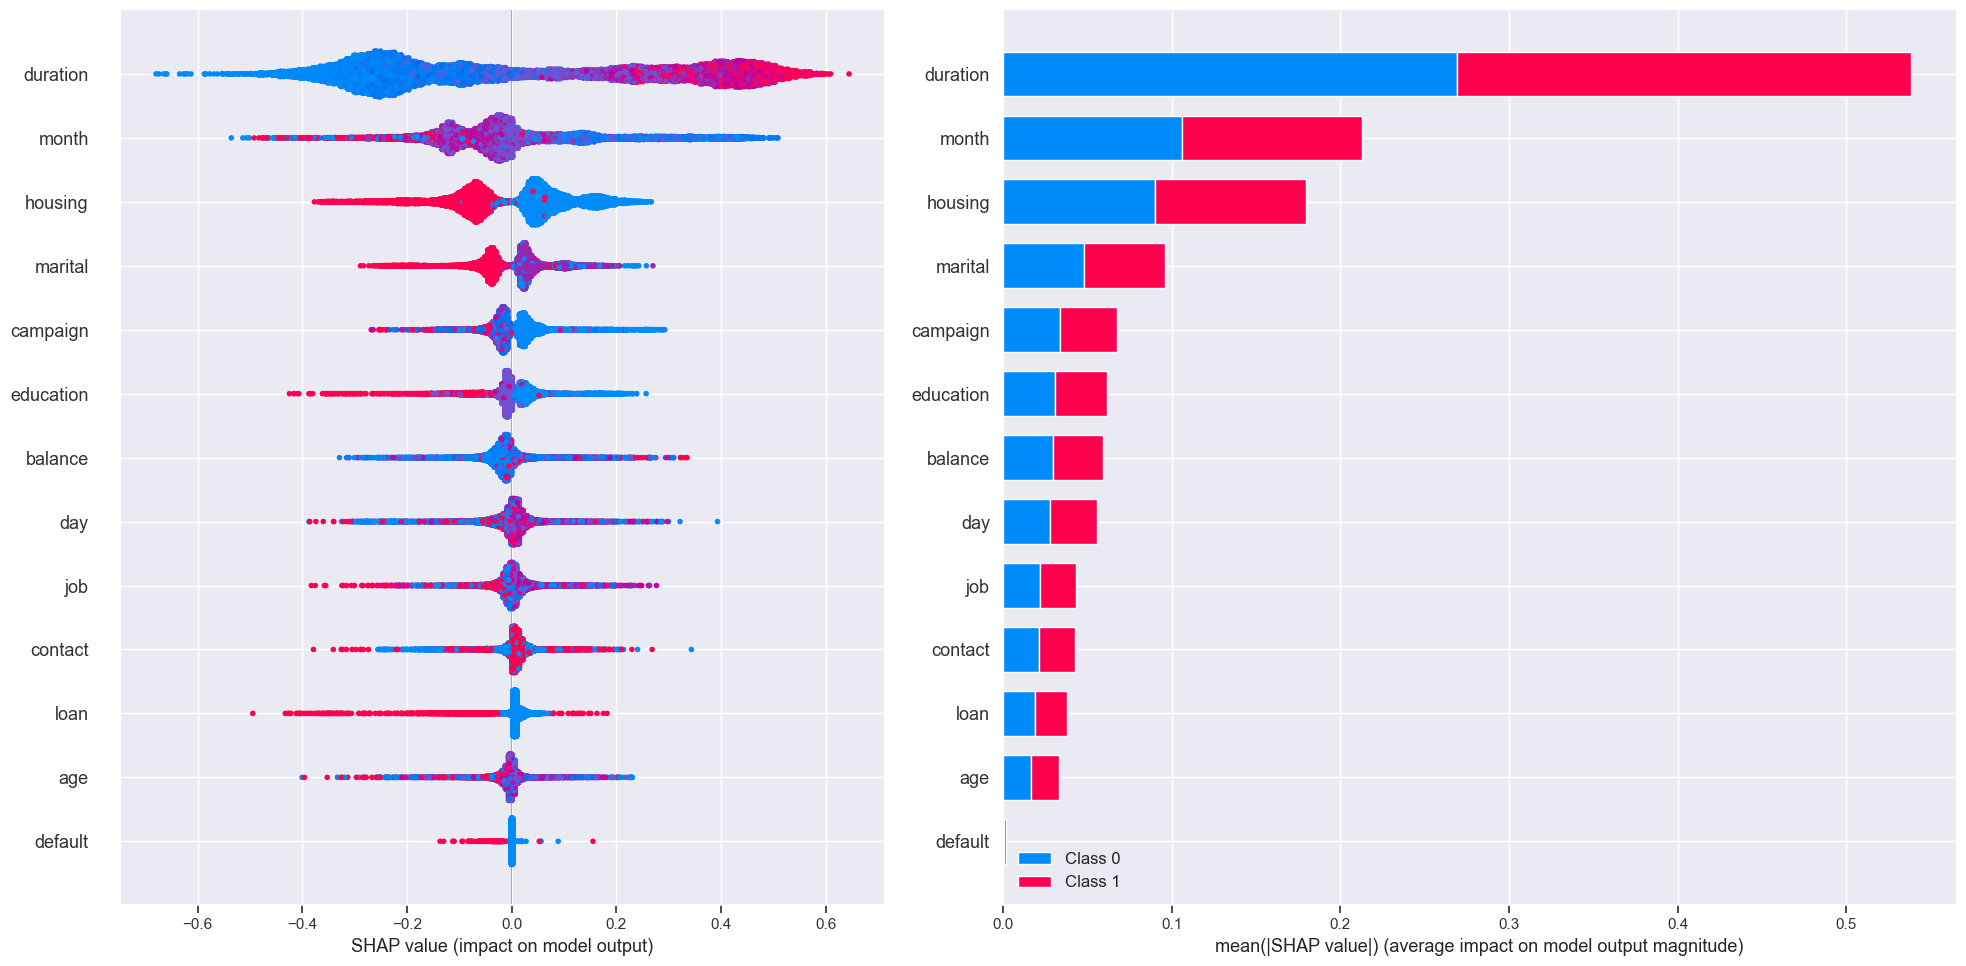

In [27]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
shap.summary_plot(shap_values[1], X_test, plot_size=None,show=False)
plt.subplot(1,2,2)
shap.summary_plot(shap_values, X_test, plot_type="bar", plot_size=None,show=False)
plt.tight_layout()
plt.show()

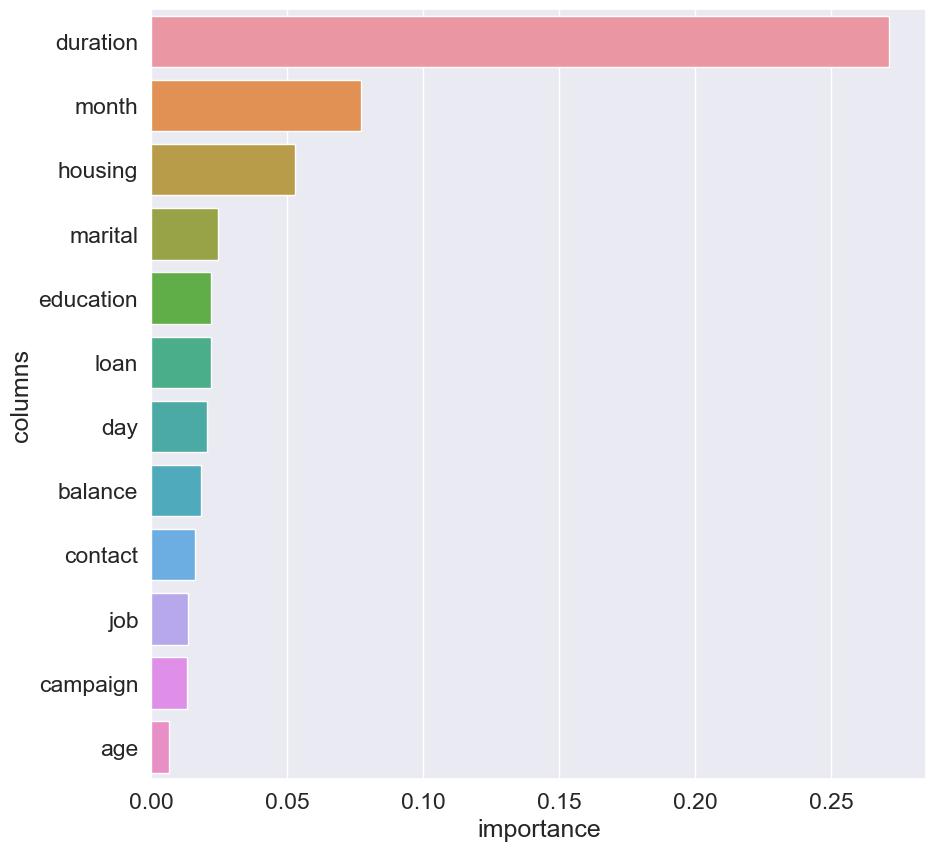

In [28]:
# We call permuation_importance and input the fitted model as model parameter
# We call it on test set, since it calculates the feature importance via its performance on our test set

result = permutation_importance(RandomForestClassifier(random_state=42).fit(X_train, y_train), X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)

# plot the features against importance  
df_ = pd.DataFrame({'columns': X_test.columns, 'importance':result.importances_mean})
df_ = df_.loc[df_['importance']>0].sort_values(['importance'],ascending=False).reset_index()
plt.subplots(1,figsize=(10,10))
sns.barplot(x="importance",y="columns",data=df_)
plt.show()

* From these plots we see that duration is the most important feature by far and then comes month and housing.

### Final Model

In [31]:
rf_hyperparams = {"n_estimators": [10,15,20,25,30,35,40,45,50,70,80,90,100,500], # number of trees used in random forest
                 "max_depth": [2,3,4,5,6], # max depth
                 "criterion": ["gini", "entropy"], # to check whether impurity or information gain is the best way to split
                 "min_samples_leaf": [2,3,4,5,6,7,8,9,10], # minimum samples beyond which a node cannot be split
                 "max_features": ["sqrt", "log2"], # to check what is the best way to limit the number of features to each tree
                 "bootstrap": [True,False] # to check whether bagging and aggregating results in a better model 
                 } 

stratified_kfold = StratifiedKFold(n_splits=5,
                                  shuffle=True,
                                  random_state=42)

rscv = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42), # estimator
                          param_distributions=rf_hyperparams, # parameters to try
                          refit = "f1", # Refit an estimator using the best found parameters on the whole dataset.
                          n_iter=20,
                          random_state=42, # make our work reproducible
                          cv=stratified_kfold,
                          n_jobs=-1)  

# fit the training data
model_rf = rscv.fit(X_train, y_train)
print(model_rf.best_params_)

{'n_estimators': 500, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 6, 'criterion': 'entropy', 'bootstrap': False}


Classification Report : 
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      7421
           1       0.88      0.92      0.90      7421

    accuracy                           0.90     14842
   macro avg       0.90      0.90      0.90     14842
weighted avg       0.90      0.90      0.90     14842

Accuracy: 90.0%


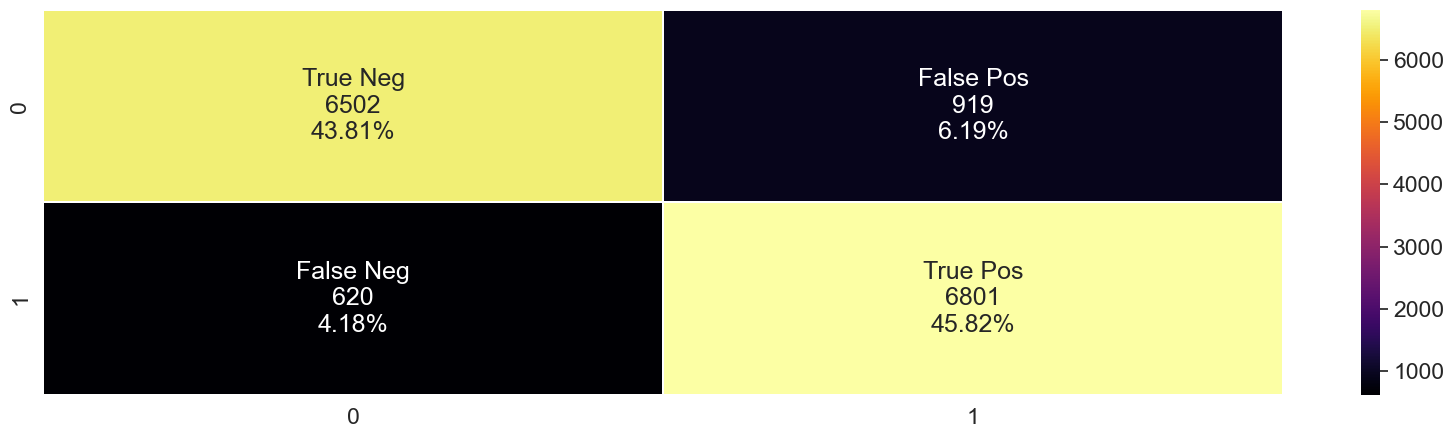

In [32]:
# train the model using the best estimator
rf_best = model_rf.best_estimator_
model = rf_best.fit(X_train, y_train)

# predictions
y_pred_rf = model.predict(X_test)

# HEATMAP-CONFUSION MATRIX
plt.figure(figsize=(20,5))
cf_matrix = confusion_matrix(y_test, y_pred_rf)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='inferno',linewidths=0.3)

# classification report
clf_report = classification_report(y_test, y_pred_rf)

print(f"Classification Report : \n{clf_report}")

print(f'Accuracy: {round(accuracy_score(y_test, y_pred_rf),2)*100}%') # correct predictions / total predictions

* Our RandomForest model has 90% accuracy at predicting if the client will subscribe or not
* We didn't do anything about the outliers (like remove them or scale them), because RandomForest can deal with them

Minimum minutes call: 0.13333333333333333
Average minutes call: 11.382642725598526
Maximum minutes call: 64.68333333333334


<AxesSubplot:xlabel='duration', ylabel='Count'>

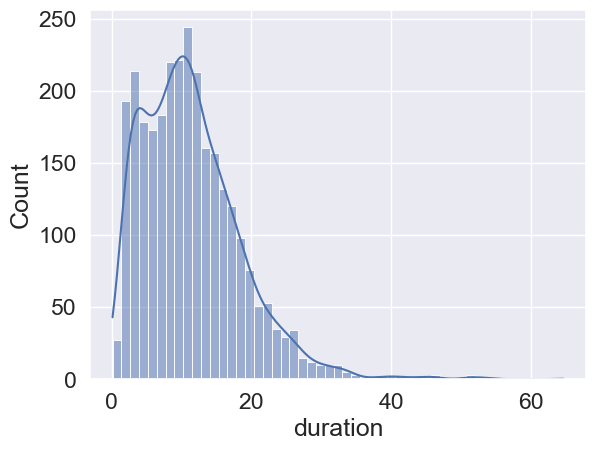

In [44]:
mincall = data[data['y']==1]['duration'].min() / 60
meancall = data[data['y']==1]['duration'].mean() / 60
maxcall = data[data['y']==1]['duration'].max() / 60

print(f'Minimum minutes call: {mincall}')
print(f'Average minutes call: {meancall}')
print(f'Maximum minutes call: {maxcall}')

sns.histplot(data[data['y']==1]['duration']/60, kde=True)

**Conclusion**:

As we saw the duration was the most important feature in predicting if the client will subsribe or not. The client who would want to buy is likely to stay longer on the call in order to know more about the program.
And the company should persuade the client with last call duration of 11 - 35 minutes. Also, our model with 90% accuracy on predicting the client's subscription or not will save them time and money.